In [1]:
from keypoint_network import build_kpextractor64, preproc_dataset
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'all_kpts_64_sizes'
dset_loc = 'all_kpts_64_sizes'

In [3]:
with open(join(dataset_loc, "Flukes/kpts/%s/model.pkl" % model_loc), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/kpts/all_kpts_64_sizes
Took 1.96 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor64()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(kpextractor)],ll.get_all_params(kpextractor))))

[(0, ((2.7822471, (8, 1, 3, 3)), conv1.W)),
 (1, ((0.26295698, (8,)), conv1.b)),
 (2, ((0.082466789, (8,)), beta)),
 (3, ((2.5518758, (8,)), gamma)),
 (4, ((1.4888952, (8,)), mean)),
 (5, ((5.4043574, (8,)), inv_std)),
 (6, ((4.0682912, (16, 8, 3, 3)), conv2.W)),
 (7, ((0.091246434, (16,)), conv2.b)),
 (8, ((0.061259724, (16,)), beta)),
 (9, ((3.6057472, (16,)), gamma)),
 (10, ((3.3158977, (16,)), mean)),
 (11, ((4.2798657, (16,)), inv_std)),
 (12, ((5.4572964, (32, 16, 3, 3)), conv3.W)),
 (13, ((0.097927861, (32,)), conv3.b)),
 (14, ((0.12780094, (32,)), beta)),
 (15, ((5.0951614, (32,)), gamma)),
 (16, ((4.6082854, (32,)), mean)),
 (17, ((6.8218894, (32,)), inv_std)),
 (18, ((7.5774889, (64, 32, 3, 3)), conv4.W)),
 (19, ((0.07434611, (64,)), conv4.b)),
 (20, ((0.12485687, (64,)), beta)),
 (21, ((7.2047243, (64,)), gamma)),
 (22, ((6.8002391, (64,)), mean)),
 (23, ((9.5991535, (64,)), inv_std)),
 (24, ((10.589459, (128, 64, 3, 3)), conv5.W)),
 (25, ((0.069192052, (128,)), conv5.b)),
 

In [6]:
[(ind, i.shape) for ind, i in enumerate(point_outputs['valid'])]

[(0, (815, 1, 64, 64)),
 (1, (815, 8, 64, 64)),
 (2, (815, 8, 32, 32)),
 (3, (815, 8, 32, 32)),
 (4, (815, 16, 32, 32)),
 (5, (815, 16, 16, 16)),
 (6, (815, 16, 16, 16)),
 (7, (815, 32, 16, 16)),
 (8, (815, 32, 8, 8)),
 (9, (815, 32, 8, 8)),
 (10, (815, 64, 8, 8)),
 (11, (815, 64, 4, 4)),
 (12, (815, 64, 4, 4)),
 (13, (815, 128, 4, 4)),
 (14, (815, 128, 2, 2)),
 (15, (815, 128, 2, 2)),
 (16, (815, 128)),
 (17, (815, 128)),
 (18, (815, 64)),
 (19, (815, 64)),
 (20, (815, 6)),
 (21, (815, 3, 2))]

(64, 64)
uint8
/home/zach/data/Flukes/CRC_combined constrained/10751-JAC93-50-01.jpg
[[  30.       165.46875]
 [ 915.       198.5625 ]
 [ 480.       308.875  ]]
[[  70.93881989  340.53973389]
 [ 772.88934326  345.6272583 ]
 [ 508.37030029  325.60357666]]
[ 179.79386902  204.50790405   32.93507767]
64


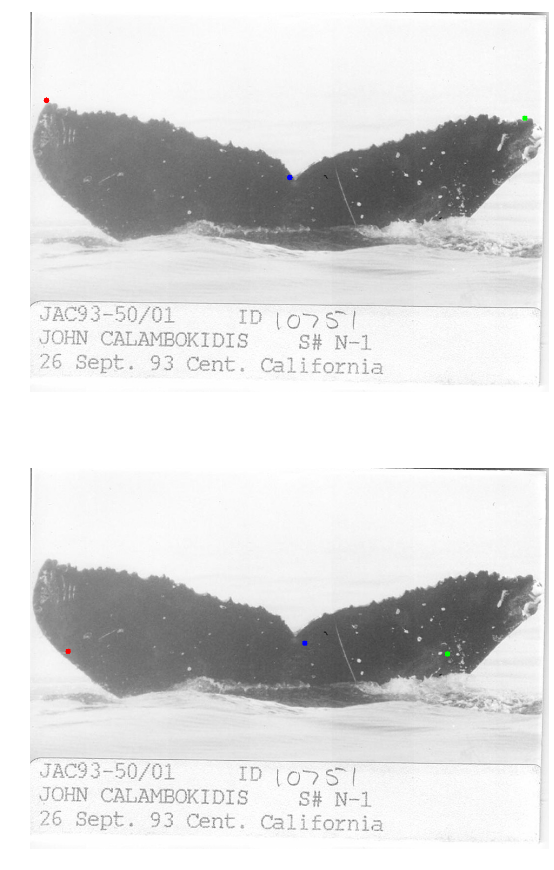

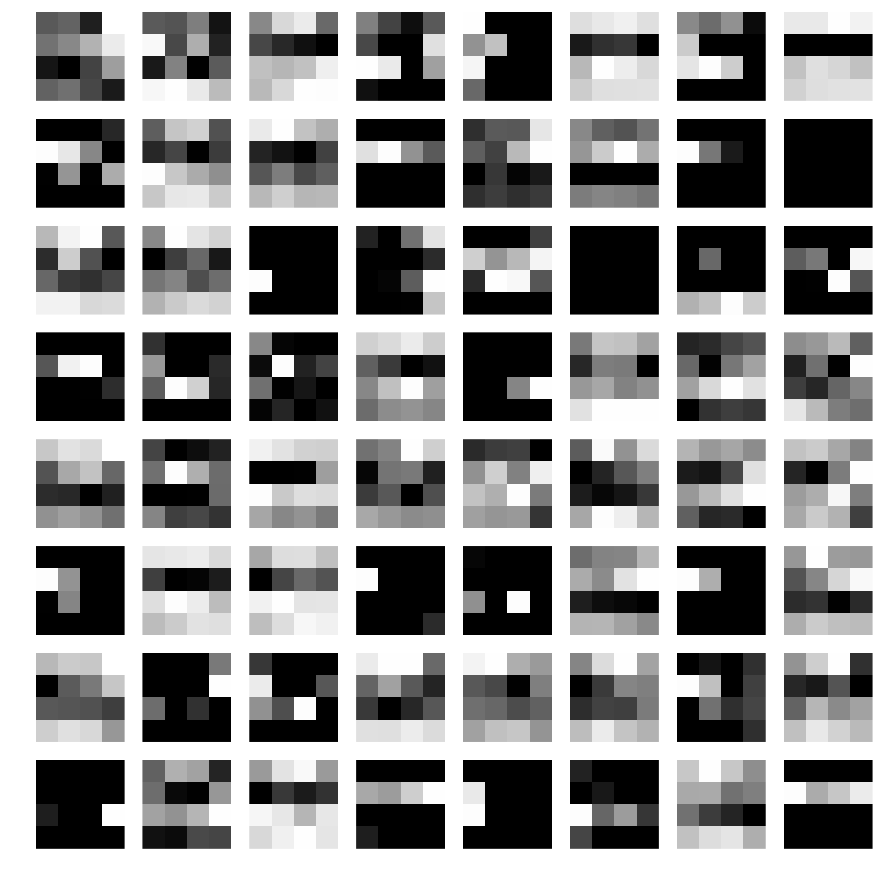

In [13]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), 5, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), 5, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), 5, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1, imgnames=None):
    # the [0] indexes into the channel
    original = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8).T
    print(original.shape)
    print(original.dtype)
    true_points = true_labels[ind]
    imgname = imgnames[ind]
    print(imgname)
    original_img = cv2.cvtColor(cv2.imread(imgname),cv2.COLOR_BGR2GRAY)
    truey, truex = original_img.shape[:2]
    #sizey, sizex = original.shape[-2:]
    sizey, sizex = (1.,1.)
    scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num = np.array([truex, truey]*3,dtype=np.float32).reshape(3,2)
    true_points_scaled = true_points * (scale_num / scale_denom)
    print(true_points_scaled)
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    gt_drawn = drawPoints(true_points_scaled, original_img)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_scaled = pred_points * (scale_num / scale_denom)
    print(pred_points_scaled)
    pred_drawn = drawPoints(pred_points_scaled, original_img)
    print(np.linalg.norm(true_points_scaled - pred_points_scaled, axis=1))
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2, figsize=(15,15))
    for i in trueax:
        i.axis('off')
    trueax[0].imshow(gt_drawn)
    trueax[1].imshow(pred_drawn)
    
    nfilters = network_stage.shape[-1]
    print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
    for i in range(square_size*square_size):
        #netax.set_gray()
        this_ax = netax[i // square_size, i % square_size]
        this_ax.axis('off')
        #this_ax.get_xaxis().set_visible(False)
        #this_ax.get_yaxis().set_visible(False)
        if i < nfilters:
            this_ax.imshow(network_stage[:,:,i], interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=12, 
            imgnames=dset_for_model[sec]['names'])

[[ 0.05544478  0.11328604]
 [ 0.93132669  0.11570169]
 [ 0.48774922  0.50856978]]
[[ 0.0528406   0.14014407]
 [ 0.91934532  0.13432483]
 [ 0.49119395  0.4018122 ]]
0.130374
0.0783262
0.087991


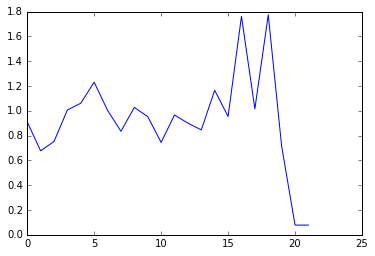

In [8]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

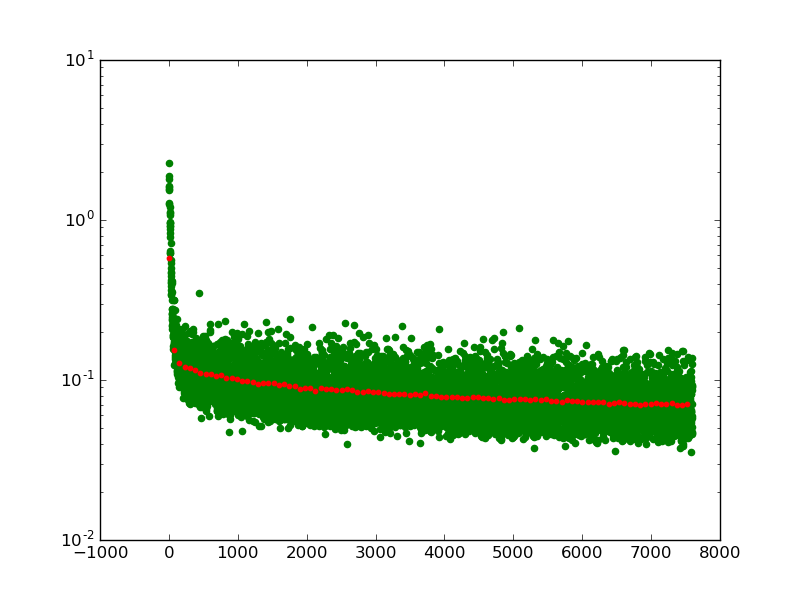

In [9]:
from IPython.display import Image 
Image(filename='./losses.png')